In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math

##### Streaming

In [10]:
def streaming_operator(f_inm, c_ai):
    '''streaming'''
    for i in range(9):
        f_inm[i] = np.roll(f_inm[i], shift=c_ai.T[i], axis=(0, 1))
    ''''''
    return f_inm

##### Collision and f<sub>eq</sub>

In [11]:
def feq(rho_nm, u_anm, c_ai, w_i):

    '''c * u'''
    cu_nm = np.einsum('ai,anm->inm', c_ai, u_anm)
    ''''''

    '''squaring cu'''
    sqcu_nm = cu_nm**2
    ''''''

    '''scalar product of the velocity vectors with itself at each lattice side'''
    usq_nm = np.einsum('anm,anm->nm', u_anm, u_anm)
    ''''''

    '''equilibrium distribution'''
    wrho_inm = np.einsum('i,nm->inm', w_i, rho_nm)
    ''''''

    '''calculating equivalent probability density function'''
    feq_inm = wrho_inm * (1 + 3 * cu_nm + 4.5 * sqcu_nm - 1.5 * usq_nm)
    ''''''

    return feq_inm

def collision(f_inm, c_ai, w_i, omega):

    '''calculating density from pdf'''
    rho_nm = np.einsum('ijk->jk', f_inm)
    ''''''

    '''calculating average velocity'''
    u_anm  = np.einsum('ai,inm->anm', c_ai, f_inm) / rho_nm
    ''''''

    '''calculating equilibrium probability density function'''
    feq_ixy = feq(rho_nm, u_anm, c_ai, w_i)
    ''''''

    return (f_inm + (omega * (feq_ixy - f_inm)))

##### Boundary conditions

In [12]:
def boundary_conditions(f_inm, rho_nm, c_ai, w_i, grid_x, grid_y):

    '''index_rigid[] stores directions bottom, bottom-left and bottom-right and the mirrored directions in opposite[]'''
    index_rigid = np.array([4, 7, 8])
    opposite_rigid = np.array([2, 5, 6])
    ''''''

    '''index_moving[] stores directions top, top-left and top-right and the mirrored directions in opposite[]'''
    index_moving = np.array([2, 5, 6])
    opposite_moving = np.array([4, 7, 8])
    ''''''

    '''wall velocity,an array of shape (2,)'''
    u_w = np.array([0, 1])
    ''''''

    c_s = 1/math.sqrt(3)

    '''calculating average value of density matrix'''
    total = 0
    for i in rho_nm:
        for j in i:
            total = total + j
    rho_average = total/(rho_nm.size)
    ''''''

    '''copying probability density function to a dummy variable'''
    f_inm_dummy = np.empty_like(f_inm)

    for i in range(9):
        for j in range(grid_x):
            for k in range(grid_y):
                f_inm_dummy[i, j, k] = f_inm[i, j, k]
    ''''''

    '''performing an inital streaming operation to update the probability density function'''
    f_inm = streaming_operator(f_inm, c_ai)
    ''''''

    rho_nm = np.einsum('ijk->jk', f_inm)

    for i in range(9):

        '''checking if we are in channels 4, 7, or 8'''
        if i in index_rigid:

            '''rigid wall boundary condition'''
            f_inm[opposite_rigid[np.where(i == index_rigid)[0][0]], -1, :] = f_inm_dummy[i, -1, :]
            ''''''

        elif i in index_moving:
            '''applying moving wall boundary condition'''
            f_inm[opposite_moving[np.where(i == index_moving)[0][0]], 0, :] = f_inm_dummy[i, 0, :] - 2 * w_i[i] * rho_average * ((c_ai[:, i] @ u_w).T / (c_s ** 2))

    '''Calulating density and velocity using pdf'''
    rho_nm = np.einsum('ijk->jk', f_inm)
    u_anm  = np.einsum('ai,inm->anm', c_ai, f_inm)
    ''''''

    return f_inm, rho_nm, u_anm, rho_average

#### Initializing constants and grid

In [40]:
time_steps = 40000
grid_x, grid_y = 50, 50

omega = 1.3
epsilon = 0.1

#### Initializing matrices

In [41]:
'''setting up initial density values'''
rho_nm = np.ones((grid_x, grid_y))
''''''

'''setting up initial velocity values'''
u_anm = np.zeros((2, grid_x, grid_y))
''''''

'''setting up weights'''
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
''''''

c_ai = np.array([[ 0,  0, -1,  0,  1, -1, -1,  1,  1],
                 [ 0,  1,  0, -1,  0,  1, -1, -1,  1]])

wall_velocity = 1
measurement_point = (grid_x)//2
velocity_field = np.empty((time_steps+1, grid_x, grid_y))
velocity_field[0] = u_anm[1]

# f_inm = np.einsum('i,jk -> ijk', w_i, rho_nm)

##### Visualizing velocity

In [ ]:
# fig, ax = plt.subplots()

'''calculating initial equilibrium pdf'''
f_inm = feq(rho_nm, u_anm, c_ai, w_i)
''''''

'''calculating initial pdf after collision'''
f_inm = collision(f_inm, c_ai, w_i, omega)
''''''

'''Deriving average density and velocity after collision'''
rho_nm = np.einsum('ijk -> jk', f_inm)
''''''

'''applying boundary conditions'''
f_inm, rho_nm, u_anm, rho_average = boundary_conditions(f_inm, rho_nm, c_ai, w_i, grid_x, grid_y)
''''''

# '''checking average density'''
# print(rho_average)
# ''''''

# '''plotting velocity in x direction over time'''
# ax.plot(u_anm[:, :, grid_y//2])
# ''''''

for i in range(time_steps):

    '''calculating subsequent collision pdf'''
    f_inm = collision(f_inm, c_ai, w_i, omega)
    ''''''

    '''Deriving density matrix after collision'''
    rho_nm = np.einsum('ijk -> jk', f_inm)
    ''''''

    '''applying boundary conditions'''
    f_inm, rho_nm, u_anm, rho_average = boundary_conditions(f_inm, rho_nm, c_ai, w_i, grid_x, grid_y)
    ''''''

    y_data = np.arange(grid_y)

    '''copying velocity into new matrix'''
    velocity_field[i+1] = u_anm[1]
    ''''''

    # '''plotting velocity in x direction over time'''
    # ax.plot(velocity_field[i, :, grid_x // 2])
    # ''''''

    '''checking average density'''
    # print(rho_average)
    # ''''''
# plt.show()


##### Better plot

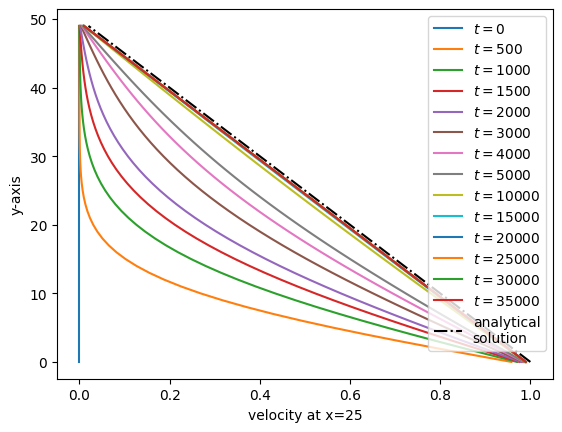

In [66]:
fig, ax = plt.subplots()
y_data = np.arange(grid_x)
for t in range(time_steps):
  if t < 2000:
    if t % 500 == 0:
      x_data = velocity_field[t, :, measurement_point]
      ax.plot(x_data, y_data, label=f"$t=${t}")
  elif t >= 200 and t<=5000:
    if t % 1000 == 0:
      x_data = velocity_field[t, :, measurement_point]
      ax.plot(x_data, y_data, label=f"$t=${t}")
  elif t > 5000:
    if t % 5000 == 0:
      x_data = velocity_field[t, :, measurement_point]
      ax.plot(x_data, y_data, label=f"$t=${t}")

ax.set_xlabel(f"velocity at x={measurement_point}")
ax.set_ylabel("y-axis")
ax.plot(np.flip((y_data+1)/grid_x*wall_velocity), y_data, "k-.", label="analytical\nsolution")
plt.legend(loc='best')
plt.show()